<a href="https://colab.research.google.com/github/abhatta1234/machineLearningAssignment/blob/main/Machine_Learning_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading essential modules and device declaration**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
import time
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader


In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")

Tesla K80


# **Loading Data from CSV** 

In [3]:
data_path = "drive/MyDrive/data/"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 

## **Sample Image Display**

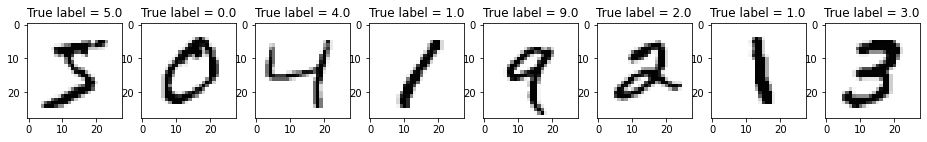

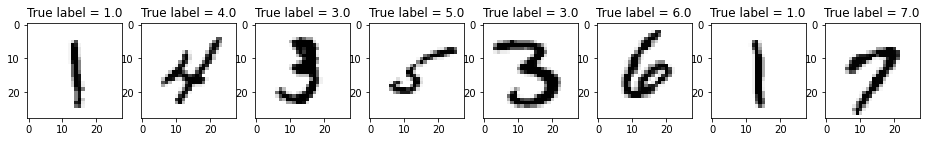

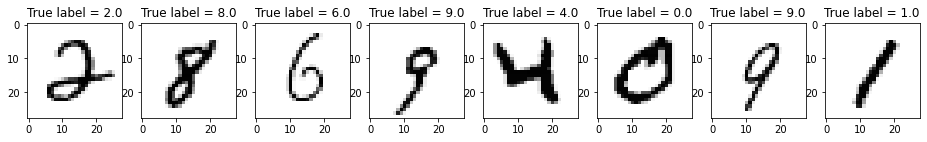

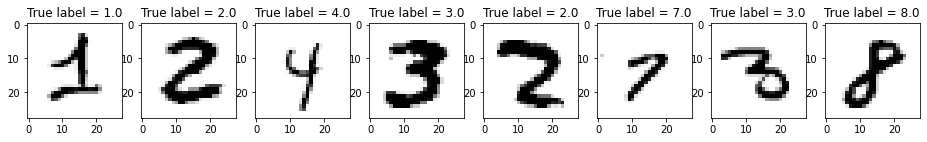

In [19]:
num_display = 32

for i in range(num_display):
    img = train_imgs[i].reshape((image_size,image_size))
    label = train_labels[i][0]
    if i % 8 == 0:
      plt.figure(figsize=(16, 4))
    plt.subplot(1, 8, i % 8 + 1)
    plt.imshow(img,cmap='Greys')
    plt.title("True label = {}".format(label))

# **MNIST CNN Implementation**

### Data pre-processing

In [4]:
image_size = 28 # width and length
image_pixels = image_size * image_size

# Normalize the pixels range from [0 255] to [0.01, 1]. 
# To avoid 0 values as inputs, each pixel is multiplied by 0.99 / 255, and then adding 0.01.
train_imgs = (np.asfarray(train_data[:, 1:]) * 0.99 / 255 + 0.01)
test_imgs = (np.asfarray(test_data[:, 1:]) * 0.99 / 255 + 0.01)

# Reshaping all the images to (1,28,28) for CNN input. 1 is the number of input channel and (28,28) is the size of the image
train_imgs = train_imgs.reshape(len(train_imgs),1,28,28)
test_imgs = test_imgs.reshape(len(test_imgs),1,28,28)


# All the labels
train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

### Custom DataReader

Implementation adapted from : pytorch forums



In [5]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
      
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

### Data Loader preparation for Train and Test Set

In [6]:
train_dataset = MyDataset(train_imgs, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,shuffle=True)

test_dataset = MyDataset(test_imgs,test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)

### Model, optimizer and Loss Function Declaration

In [7]:
class CNN(nn.Module):

  def __init__(self):

    super(CNN,self).__init__()

    self.conv_stack1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
            )

    self.conv_stack2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)
            )

    self.fc1 = nn.Linear(in_features = 800,out_features=256)
    self.fc2 = nn.Linear(in_features = 256, out_features=10)
    

  def forward(self,x):

    outp = self.conv_stack1(x)
    outp = self.conv_stack2(outp)

    outp = outp.reshape(outp.size(0), -1)

    outp = self.fc1(outp)

    return self.fc2(outp)
    

In [8]:
model_CNN = CNN()

#Sending model to GPU if available
model_CNN.to(device)

print(model_CNN)


print(summary(model_CNN,input_size=(1,28,28)))

CNN(
  (conv_stack1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             160
              ReLU-2           [-1, 16, 30, 30]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
      

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
# Loss function declaration

criterion = nn.CrossEntropyLoss()

# Optimizer Declaration

optimizer = torch.optim.Adam(model_CNN.parameters(),lr = 0.001)

##**Training Phase**

In [10]:
start_time = time.time()
epochs = 61
batch_size = 64

loss_training = []
accuracy_training = []

model_CNN.train()

for epoch in range(epochs):
  accuracy = 0
  loss_train = 0

  for images,labels in iter(train_loader): 

    labels = labels.flatten()

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model_CNN(images)
    
    loss = criterion(output,labels)

    loss.backward()

    optimizer.step()

    loss_train += loss.item()/ batch_size

    max_element, max_indices = torch.max(output,dim=1)

    accuracy += torch.sum(max_indices == labels)

  loss_training.append(loss_train)
  accuracy_per = accuracy / len(train_data) * 100
  accuracy_training.append(accuracy_per)

  if epoch % 10 == 0:
    print("The loss in {}-th epoch is {}. Accuracy = {:.3f}%".format(epoch,loss_train,accuracy_per))

end_time = time.time()

print(end_time-start_time)

The loss in 0-th epoch is 2.9283179936537636. Accuracy = 93.780%
The loss in 10-th epoch is 0.24892457698467751. Accuracy = 99.428%
The loss in 20-th epoch is 0.13003592930980234. Accuracy = 99.700%
The loss in 30-th epoch is 0.11901207855589263. Accuracy = 99.720%
The loss in 40-th epoch is 0.06870876900718828. Accuracy = 99.855%
The loss in 50-th epoch is 0.09581771201869477. Accuracy = 99.822%
The loss in 60-th epoch is 0.08352749519016425. Accuracy = 99.823%
356.469957113266


### Loss and Accuracy during Training Visulization

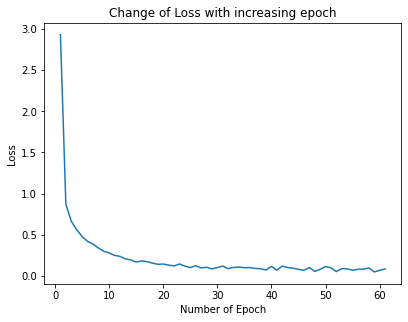

In [11]:
plt.rcParams["figure.figsize"] = (6.4,4.8)

# Loss over training visulization
x = np.arange(len(loss_training)) + 1
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.title("Change of Loss with increasing epoch")
plt.plot(x,loss_training)

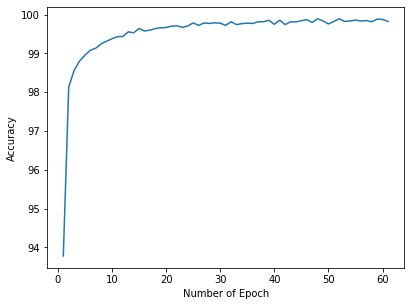

In [12]:
# Accuracy over training visulization
x = np.arange(len(loss_training)) + 1
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy")
plt.plot(x,accuracy_training)

## **Testing Phase**

In [13]:
all_label = (torch.tensor([],dtype=torch.int64)).to(device)
pred_label = (torch.tensor([],dtype=torch.int64)).to(device)

loss_test = 0
accuracy_test = 0


model_CNN.eval()

with torch.no_grad():
  
  for images,labels in iter(test_loader):

    labels = labels.flatten()

    images = images.to(device)
    labels = labels.to(device)

    output = model_CNN(images)
    loss = criterion(output,labels)

    loss_test += loss.item()/ batch_size

    _, max_indices = torch.max(output,dim=1)

    labels = torch.squeeze(labels)

    all_label = torch.cat((all_label,labels),dim=0)
    pred_label = torch.cat((pred_label,max_indices),dim=0)

    accuracy_test += torch.sum(max_indices == labels)


accuracy_per = accuracy_test / len(test_data) * 100 
print("The loss in test data is : {} Accuracy = {:.3f}%".format(loss_test,accuracy_per))

The loss in test data is : 0.22678451989889467 Accuracy = 98.720%


In [14]:
# Self Defined Confusion matrix calculation

confusion_matrix = torch.zeros(10,10,dtype= torch.int64)
val = torch.stack((all_label,pred_label),dim = 1)
for i in val:
  act,pred = i.tolist()
  confusion_matrix[act,pred] = confusion_matrix[act,pred] + 1
print(confusion_matrix)

tensor([[ 976,    0,    1,    0,    0,    0,    1,    0,    1,    1],
        [   0, 1128,    0,    5,    0,    2,    0,    0,    0,    0],
        [   2,    1, 1025,    2,    1,    0,    0,    1,    0,    0],
        [   0,    0,    2, 1005,    0,    3,    0,    0,    0,    0],
        [   0,    0,    0,    1,  967,    0,    0,    2,    1,   11],
        [   0,    0,    0,    6,    0,  884,    2,    0,    0,    0],
        [   2,    4,    0,    0,    2,    7,  941,    0,    2,    0],
        [   0,    6,   19,    2,    0,    0,    0,  998,    1,    2],
        [   1,    0,    3,    4,    1,    2,    2,    1,  958,    2],
        [   2,    0,    2,    6,    4,    3,    0,    2,    0,  990]])


## **Model Statistics and Confusion Matrix using Sklearn**

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import numpy as np

# Sending all the labels data to cpu and converting it to numpy
labels = all_label.cpu().numpy()
predictions = pred_label.cpu().numpy()

#print(f1_score(labels,predictions,average='macro'))
cm = confusion_matrix(labels,predictions)

recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

recall = np.mean(recall)
precision = np.mean(precision)

print("{:.5f}".format(recall))
print("{:.5f}".format(precision))

f1_score = (2 * precision * recall) / (precision + recall)
print("{:.5f}".format(f1_score))

0.98716
0.98729
0.98722


In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tabulate import tabulate


recall_val = recall_score(labels,predictions,average=None)
precision_val = precision_score(labels,predictions,average=None)
f1_val = f1_score(labels,predictions,average=None)

val = list(map(list, zip(precision_val,recall_val,f1_val)))

print(tabulate(val, headers=["Class","Precision","Recall", "F1-Score"],tablefmt="github",showindex="always"))

|   Class |   Precision |   Recall |   F1-Score |
|---------|-------------|----------|------------|
|       0 |    0.992879 | 0.995918 |   0.994396 |
|       1 |    0.990342 | 0.993833 |   0.992084 |
|       2 |    0.974335 | 0.993217 |   0.983685 |
|       3 |    0.974782 | 0.99505  |   0.984811 |
|       4 |    0.991795 | 0.984725 |   0.988247 |
|       5 |    0.981132 | 0.991031 |   0.986057 |
|       6 |    0.994715 | 0.982255 |   0.988445 |
|       7 |    0.994024 | 0.970817 |   0.982283 |
|       8 |    0.994808 | 0.983573 |   0.989158 |
|       9 |    0.984095 | 0.981169 |   0.98263  |


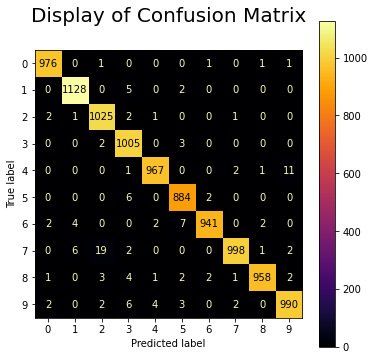

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,6)
labels_plot = np.arange(10)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=labels_plot)
disp.plot(cmap = 'inferno', values_format='d')
plt.title("Display of Confusion Matrix\n",size = 20)
plt.show()

# **MNIST MLP implementation**

### Data preprocessing and demo image displays

In [18]:
image_size = 28 # width and length
image_pixels = image_size * image_size

# Normalize the pixels range from [0 255] to [0.01, 1]. 
# To avoid 0 values as inputs, each pixel is multiplied by 0.99 / 255, and then adding 0.01.
train_imgs = np.asfarray(train_data[:, 1:]) * 0.99 / 255 + 0.01
test_imgs = np.asfarray(test_data[:, 1:]) * 0.99 / 255 + 0.01

train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])

### Data Loader preparation for Train and Test Set

In [20]:
batch_size = 64
shuffle = True

# DataLoader for Train Data

# concatenating images with their respective labels across column 
# Each row is long vector with first element as label and rest for image representation

train_data = np.concatenate((train_labels,train_imgs),axis=1)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=shuffle)


# DataLoader for Test Data

test_data = np.concatenate((test_labels,test_imgs),axis=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=shuffle)

### Model, optimizer and Loss Function Declaration


In [21]:
# Dynamic model implementation for MLP

class Net(nn.Module):

    def __init__(self,in_channel,out_channel,num_hidden_layers):

      super(Net, self).__init__()

      self.num_hidden_layers = num_hidden_layers

      self.hiddenfc = nn.ModuleList()

      for i in range(num_hidden_layers):
        
        ## Reducing the feature size by half in each subsequent hidden layer
        self.hiddenfc.append(nn.Linear( in_channel//(2**i), in_channel//(2**(i+1))))

      # final hidden layer to ouput layer
      self.outputfc = nn.Linear(in_channel//(2**(i+1)),out_channel)

    def forward(self, x):

      for layers in self.hiddenfc:
        x = F.relu(layers(x))
      
      x = self.outputfc(x)
      
      return x


In [22]:
model = Net(784,10,2)

# Sending model to GPU is available
model.to(device)

print(model)
print("\n The model summary and number of parameters required is shown below: \n")
print(summary(model,input_size = (64,1,784)))

Net(
  (hiddenfc): ModuleList(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): Linear(in_features=392, out_features=196, bias=True)
  )
  (outputfc): Linear(in_features=196, out_features=10, bias=True)
)

 The model summary and number of parameters required is shown below: 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 64, 1, 392]         307,720
            Linear-2           [-1, 64, 1, 196]          77,028
            Linear-3            [-1, 64, 1, 10]           1,970
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.29
Params size (MB): 1.48
Estimated Total Size (MB): 1.96
----------------------------------------------------------------
None


In [23]:
# Loss function declaration
criterion = nn.CrossEntropyLoss()

# Optimizer Declaration
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

##**Training Phase**

In [24]:
start_time = time.time()
epochs = 61

batch_size = 64
loss_training = []
accuracy_training = []

model.train()

for epoch in range(epochs):
  accuracy = 0
  loss_train = 0

  for i in iter(train_loader): 

    label = torch.tensor(i[:,:1],dtype=torch.long)
    label = torch.reshape(label,(-1,))
    label = label.to(device)

    img = torch.tensor(i[:,1:]).float()
    img = img.to(device)

    # Optimizer accumulates value so set zero for each iteration   
    optimizer.zero_grad()

    output = model(img)
    loss = criterion(output,label)

    # Backprop step
    loss.backward()

    # Stepping in the opposite direction of gradient
    optimizer.step()

    loss_train += loss.item()/ batch_size

    max_element, max_indices = torch.max(output,dim=1)

    accuracy += torch.sum(max_indices == label)

  loss_training.append(loss_train)
  accuracy_per = accuracy / len(train_data) * 100 
  accuracy_training.append(accuracy_per)

  if epoch % 10 == 0:
    print("The loss in {}-th epoch is {}. Accuracy = {:.3f}%".format(epoch,loss_train,accuracy_per))

end_time = time.time()

print("\nTime taken to finish the training with {} epoch is {:.3f} seconds".format(epochs,end_time-start_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


The loss in 0-th epoch is 24.338077373802662. Accuracy = 58.002%
The loss in 10-th epoch is 3.0574227285105735. Accuracy = 94.050%
The loss in 20-th epoch is 1.8574988321342971. Accuracy = 96.368%
The loss in 30-th epoch is 1.244531741103856. Accuracy = 97.612%
The loss in 40-th epoch is 0.887079167237971. Accuracy = 98.348%
The loss in 50-th epoch is 0.6564836677425774. Accuracy = 98.827%
The loss in 60-th epoch is 0.49318634506562375. Accuracy = 99.183%

Time taken to finish the training with 61 epoch is 137.406 seconds


### Loss and Accuracy during Training Visulization

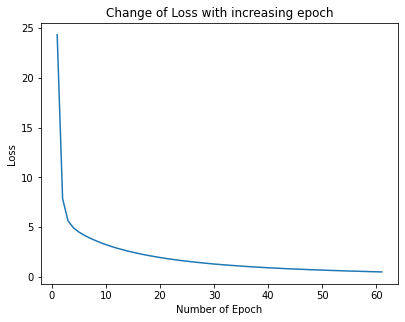

In [25]:
plt.rcParams["figure.figsize"] = (6.4,4.8)

# Loss over training visulization
x = np.arange(len(loss_training)) + 1
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.title("Change of Loss with increasing epoch")
plt.plot(x,loss_training)

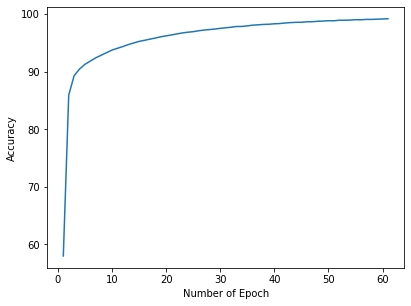

In [26]:
# Accuracy over training visulization
x = np.arange(len(loss_training)) + 1
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy")
plt.plot(x,accuracy_training)

## **Testing Phase**

In [27]:
all_label = (torch.tensor([],dtype=torch.int64)).to(device)
pred_label = torch.tensor([],dtype=torch.int64).to(device)

loss_test = 0
accuracy_test = 0

model.eval()

with torch.no_grad():
  
  for i in iter(test_loader):
    
    label = torch.tensor(i[:,:1],dtype=torch.long)
    label = torch.reshape(label,(-1,))
    label = label.to(device)

    img = torch.tensor(i[:,1:]).float()
    img = img.to(device)

    output = model(img)
    loss = criterion(output,label)

    loss_test += loss.item()/ batch_size

    _, max_indices = torch.max(output,dim=1)

    label = torch.squeeze(label)

    all_label = torch.cat((all_label,label),dim=0)
    pred_label = torch.cat((pred_label,max_indices),dim=0)

    accuracy_test += torch.sum(max_indices == label)


accuracy_per = accuracy_test / len(test_data) * 100 
print("The loss in test data is : {} Accuracy = {:.3f}%".format(loss_test,accuracy_per))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


The loss in test data is : 0.17049492809019284 Accuracy = 97.770%


### Self Defined Confusion Matrix Display

In [28]:
# Self Defined Confusion matrix calculation
confusion_matrix = torch.zeros(10,10,dtype= torch.int64)
val = torch.stack((all_label,pred_label),dim = 1)
for i in val:
  act,pred = i.tolist()
  confusion_matrix[act,pred] = confusion_matrix[act,pred] + 1
  
print(confusion_matrix)

tensor([[ 966,    0,    0,    2,    0,    2,    5,    1,    2,    2],
        [   0, 1125,    2,    1,    0,    1,    2,    1,    3,    0],
        [   4,    3, 1007,    3,    2,    0,    3,    7,    3,    0],
        [   0,    0,    4,  986,    1,    6,    0,    6,    3,    4],
        [   1,    0,    5,    0,  955,    0,    7,    3,    0,   11],
        [   3,    1,    0,    5,    1,  870,    6,    0,    3,    3],
        [   4,    3,    1,    0,    2,    4,  943,    0,    1,    0],
        [   2,    7,    7,    4,    0,    0,    1, 1002,    1,    4],
        [   6,    0,    2,    5,    3,    3,    7,    3,  941,    4],
        [   2,    3,    0,    4,    8,    4,    1,    2,    3,  982]])


## **Model Statistics and Confusion Matrix using Sklearn**

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import numpy as np

labels = all_label.cpu().numpy()
predictions = pred_label.cpu().numpy()

cm = confusion_matrix(labels,predictions)

recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

recall = np.mean(recall)
precision = np.mean(precision)

print("Recall Score: {:.5f}".format(recall))
print("\nPrecision Score: {:.5f}".format(precision))

f1_score = (2 * precision * recall) / (precision + recall)
print("\nF1- Score: {:.5f}".format(f1_score))


Recall Score: 0.97752

Precision Score: 0.97759

F1- Score: 0.97755


In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



recall_val = recall_score(labels,predictions,average=None)
precision_val = precision_score(labels,predictions,average=None)
f1_val = f1_score(labels,predictions,average=None)


from tabulate import tabulate


val = list(map(list, zip(precision_val,recall_val,f1_val)))


print(tabulate(val, headers=["Class","Precision","Recall", "F1-Score"],tablefmt="github",showindex="always"))

|   Class |   Precision |   Recall |   F1-Score |
|---------|-------------|----------|------------|
|       0 |    0.977733 | 0.985714 |   0.981707 |
|       1 |    0.985114 | 0.991189 |   0.988142 |
|       2 |    0.979572 | 0.975775 |   0.97767  |
|       3 |    0.976238 | 0.976238 |   0.976238 |
|       4 |    0.98251  | 0.972505 |   0.977482 |
|       5 |    0.977528 | 0.975336 |   0.976431 |
|       6 |    0.967179 | 0.984342 |   0.975685 |
|       7 |    0.977561 | 0.974708 |   0.976132 |
|       8 |    0.980208 | 0.966119 |   0.973113 |
|       9 |    0.972277 | 0.973241 |   0.972759 |


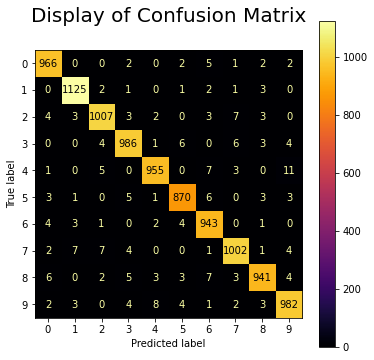

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,6)
labels_plot = np.arange(10)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels=labels_plot)
disp.plot(cmap = 'inferno', values_format='d')
plt.title("Display of Confusion Matrix\n",size = 20)
plt.show()